# Identify home and work location in Varaset

In [1]:
# date: 12/20/2021
# author: Ziwen
# task: identify home and work location in Varaset
import os, sys, gc
import pandas as pd
import numpy as np
import yaml
import os
import glob
import ipystata

from google.cloud import storage
from google.cloud import bigquery

path = os.path.expanduser('~')
# set up env credential variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path + '/Dropbox/Amenity/source/analysis/veraset_gravy_gps_sample/firm-exit-3608acd14b06.json'
client = bigquery.Client()

import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

## select & append raw ping records that belong to devices in CA
By "belong to CA" I mean these devices have recorded stays at *at least one non-home & non-work POI* in CA. Because if the device owner has been to only work or home, there would be no meaningful trip chain. 

In [2]:
# set up default working dataset
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.ping_ca_01' # ping_ca_01 is generated via console. can be done anywhere easily
job_config = bigquery.QueryJobConfig(write_disposition='WRITE_APPEND', # APPEND, all 30 days
                                     destination=destination_table,
                                     default_dataset=default_dataset)

In [18]:
# loop over 30 tables (oct02 - oct31)
day = [str(i).zfill(2) for i in range(2, 32)]
print(day)

do not run

for x in day:
    # the sql command itself performs just the join
    append_joined_tables = f'''  
        SELECT `movements_2021oct''' + x + f'''`.*
        FROM `unique_id`
        INNER JOIN `movements_2021oct''' + x + f'''` 
        ON `unique_id`.`caid` = `movements_2021oct''' + x + f'''`.`caid`'''
    
    query_job = client.query(append_joined_tables, job_config=job_config)
    query_job.result() # Wait for result to finish. Can let it run asynchronously by just omitting this line
    

['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [8]:
# delete movements data
day = [str(i).zfill(2) for i in range(1, 32)]
print(day)

for x in day:
    client.query(f"drop table if exists `firm-exit.veraset_visits.movements_2021oct" + x + f"`")

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [ ]:
# number of devices in raw ping data in CA
job_config_sum = bigquery.QueryJobConfig(destination=destination_table, default_dataset=default_dataset)
query_sum = f'''
    select count(distinct caid) from `ping_ca_01`
'''

num_devices = client.query(query_sum, job_config = job_config_sum).to_dataframe()
print(num_devices)

## impute home and work locations
Conditions for home/work location imputation
1. home is the most visited overnight location
2. work is the most visited weekday daytime location (excl identified homes)

In [7]:
# label overnight and weekday-daytime records
destination_table = 'firm-exit.veraset_visits.time_converted_raw_ping'
job_config = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE', # overwrite
                                     destination=destination_table,
                                     default_dataset = default_dataset)

do not run

query_label = f'''
    with time_converted_table as
    (select 
        -- take necessary variables and calculation
        caid as caid, 
        datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour) as PDT_time,
        extract(hour from datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as hofd,
        format_datetime('%A', datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as weekday,
        format_datetime('%r', datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as time_of_day,
        substr(geo_hash, 1, 7) as geohash7,
        latitude as latitude,
        longitude as longitude
    from `firm-exit.veraset_visits.ping_ca_01`)
    select time_converted_table.*, 
        case 
            -- overnight indicator: 7pm to 7am of the next day
            when (hofd >= 19 and hofd <= 23) or (hofd >= 0 and hofd < 7) then 'overnight'
            -- weekday daytime indicator: 8am to 6pm from mon to fri
            when (weekday = 'Monday' or weekday = 'Tuesday' or weekday = 'Wednesday' or weekday = 'Thursday' or weekday = 'Friday') and (hofd >= 8) and (hofd < 18) then 'weekday_daytime'
            else NULL
        end
        as time_indicator
    from time_converted_table
'''

query_job = client.query(query_label, job_config=job_config)
query_job.result() 

In [4]:
# count number of records at each geohash7 region, and take the average of lat & lng
# take only the most common overnight location as a candidate for home
# and take the firsr and second most common weekday daytime location as candidates for work
destination_table = 'firm-exit.veraset_visits.time_converted_raw_ping'
job_config = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE', # overwrite
                                     destination=destination_table,
                                     default_dataset = default_dataset)

do not run

query_group = f'''
    with grouped_raw_ping as
    -- collapse data to device-geohash7 region
    (select 
        caid as caid, 
        countif(time_indicator = 'overnight') as num_records_overnight, 
        countif(time_indicator = 'weekday_daytime') as num_records_weekday_daytime,
        avg(latitude) as avg_lat, 
        avg(longitude) as avg_lng,
        avg(hofd) as avg_hofd, 
        geohash7 as geohash7
    from `firm-exit.veraset_visits.time_converted_raw_ping`
    group by caid, geohash7
    ), ranked_raw_ping as
    -- rank counted number of records (there could be ties)
    (select
        grouped_raw_ping.*,
        dense_rank() over (partition by grouped_raw_ping.caid order by grouped_raw_ping.num_records_overnight DESC) as rank_home,
        dense_rank() over (partition by grouped_raw_ping.caid order by grouped_raw_ping.num_records_weekday_daytime DESC) as rank_work
     from grouped_raw_ping
    )
    select 
        *
    from ranked_raw_ping
    -- keep only top ranked home location and top and second ranked work location (in case top work is already identified as home)
    where (rank_home = 1 and num_records_overnight != 0) or (rank_work = 1 and num_records_weekday_daytime !=0) or (rank_work = 2 and num_records_weekday_daytime !=0)
    order by caid
'''


query_job = client.query(query_group, job_config=job_config)
query_job.result() 

## (obtain data from gcs)
from here the data size is down to about 1GB, so it's suitable to move the data to be processed locally. Things like imputing home/work locations that do not require sophisticated statistical analyses can be perfomed either by sql or by python. For downloading data, either
1. convert the returned obj to df
    run the following  
    `home_work_candidates = query_job.to_dataframe()`  
2. export to gcs and download to local, then read (see following)

would work (at no cost). The difference is that the first approach needs to be executed while query obj is still active, and the second can be executed anytime upon any tables stored in gcs or in bq workplaces.

In [ ]:
# export to gcs and download
project = "firm-exit"
dataset_id = "veraset_visits"
table_id = "time_converted_raw_ping"

destination_uri = "gs://{}/{}".format('verasetsample', "home_work_candidates*.csv")
dataset_ref = bigquery.DatasetReference(project, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

print(
    "Exported {}:{}.{} to {}".format(project, dataset_id, table_id, destination_uri)
)

# download data from gcs to our dropbox
file_index = [i for i in range(7)]

for x in file_index:
    # Initialise a client
    storage_client = storage.Client("firm-exit")
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("verasetsample")
    # Create a blob object from the filepath
    blob = bucket.blob("home_work_candidates00000000000{}.csv".format(str(x)))
    # Download the file to a destination
    blob.download_to_filename(path + '/Dropbox/Amenity/data/derived/veraset_gravy_gps_sample/veraset/home_work_candidates_{}.csv'.format(str(x)))
    # Delete after exporting, otherwise costs storage fees
    blob.delete()

In [2]:
# import home_work_candidates
read_path = path + '/Dropbox/Amenity/data/derived/veraset_gravy_gps_sample/veraset'
all_files = glob.glob(read_path + "/home_work_candidates_*.csv")

temp = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    temp.append(df)

home_work_candidates = pd.concat(temp, axis=0, ignore_index=True)
home_work_candidates.head()

,caid,num_records_overnight,num_records_weekday_daytime,avg_lat,avg_lng,avg_hofd,geohash7,rank_home,rank_work
0,00000025e6f6a133694c2037f5bf2dee33224a6c6cb963...,25,93,34.960176,-120.432237,13.942029,9q4qgkr,3,1
1,00000025e6f6a133694c2037f5bf2dee33224a6c6cb963...,27,51,34.963457,-120.428963,17.669903,9q4qgsf,2,2
2,00000025e6f6a133694c2037f5bf2dee33224a6c6cb963...,52,0,34.960176,-120.435512,20.000000,9q4qgkm,1,8
3,000008e0d27bdfd2bfa5b6d33694233e209fa627b6e0f4...,0,19,33.970585,-117.679718,17.000000,9qh360h,2,2
4,000008e0d27bdfd2bfa5b6d33694233e209fa627b6e0f4...,3,24,33.967308,-117.679718,17.333333,9qh34ps,1,1


In [5]:
# take home candidates from home_work_candidates
# there could be multiple home location candidates for a single device
home_candidates = home_work_candidates[(home_work_candidates['rank_home']==1) & (home_work_candidates['num_records_overnight']!=0)]
display(home_candidates.count(), home_candidates.caid.nunique())

# take work candidates from home_work_candidates
work_candidates = home_work_candidates[(home_work_candidates['rank_work'] <= 2) & (home_work_candidates['num_records_weekday_daytime']!=0)]
display(work_candidates.count(), work_candidates.caid.nunique())

caid                           4285172
num_records_overnight          4285172
num_records_weekday_daytime    4285172
avg_lat                        4285172
avg_lng                        4285172
avg_hofd                       4285172
geohash7                       4285172
rank_home                      4285172
rank_work                      4285172
dtype: int64

4202403

caid                           7438215
num_records_overnight          7438215
num_records_weekday_daytime    7438215
avg_lat                        7438215
avg_lng                        7438215
avg_hofd                       7438215
geohash7                       7438215
rank_home                      7438215
rank_work                      7438215
dtype: int64

3991587

In [5]:
median_hofd_work = work_candidates["avg_hofd"].median()
median_hofd_work

13.880685946810042

In [4]:
home_candidates = home_candidates.assign(ties = home_candidates.duplicated(subset=['caid'], keep=False)) # mark ties

# for ties, take the one with avg_hofd closest to 1am (mid of 7pm to 7am overnight window)
# not the median/mean hofd of all home candidates because the mean/median is in daytime
home_candidates['dev_1am'] = home_candidates['avg_hofd'].apply(lambda x: abs(x-1) if x <= 13 else abs(25-x))
home_candidates['rank_ties'] = home_candidates[home_candidates['ties']==True].groupby('caid')['dev_1am'].rank(method="min", ascending=True)

home_candidates = home_candidates[(home_candidates['rank_ties']==1)|(home_candidates['ties']==False)]

In [5]:
# for remaining ties, no reason to prefer one to another, select any [only a very small proportion]
home_candidates['still_ties']=home_candidates.duplicated(subset=['caid'], keep=False) # mark remaining ties
home_candidates = home_candidates.drop_duplicates(subset=['caid'], keep='first')

display(home_candidates.caid.nunique())
home_locations = home_candidates

home_locations.to_csv(path+'/Dropbox/Amenity/data/analysis/veraset_gravy_gps_sample/varaset_home_locations', sep=',', mode='w')

4202403

In [6]:
# join identified home locations to work candidates, and remove these already identified home locations
identified_homes = home_locations[['caid', 'geohash7']]
identified_homes.columns = ['caid','home_geohash7']
work_candidates=work_candidates.join(identified_homes.set_index('caid'), on='caid')

In [7]:
# count the number of work candidates that are ranked top, second
num_top = work_candidates[work_candidates['rank_work']==1].groupby('caid')['caid'].count().to_frame('num_top')
work_candidates = work_candidates.join(num_top, on='caid')

num_second = work_candidates[work_candidates['rank_work']==2].groupby('caid')['caid'].count().to_frame('num_second')
work_candidates = work_candidates.join(num_second, on='caid')
work_candidates['num_second'] = work_candidates['num_second'].fillna(0)

In [8]:
# narrow down the candidate pool a bit, still allowing ties
# remove home locations, except for when there's no other back-up work locations
work_candidates = work_candidates[(work_candidates['geohash7']!=work_candidates['home_geohash7']) 
                                  | ((work_candidates['geohash7']==work_candidates['home_geohash7']) & (work_candidates['num_top']==1) & (work_candidates['num_second']==0))]

# now that work candidates no more overlap with home locations (except for potential WFH)
# let's re-rank work candidates and keep only new top ranked work candidates
work_candidates['new_rank_work'] = work_candidates.groupby('caid')['num_records_weekday_daytime'].rank(method="min",ascending=False)
work_candidates = work_candidates[work_candidates['new_rank_work']==1]

In [9]:
# now do the same done with home candidates to select among ties
work_candidates['ties'] = work_candidates.duplicated(subset=['caid'], keep=False) # mark ties

# for ties, take the one with avg_hofd closest to 1pm (mid of 8am to 6pm overnight window)
# very close to median/mean hofd of all work candidates
work_candidates['dev_1pm'] = work_candidates['avg_hofd'].apply(lambda x: abs(x-13))
work_candidates['rank_ties'] = work_candidates[work_candidates['ties']==True].groupby('caid')['dev_1pm'].rank(method="min", ascending=True)

work_candidates = work_candidates[(work_candidates['rank_ties']==1)|(work_candidates['ties']==False)]

In [10]:
# for remaining ties, no reason to prefer one to another, select any [only a very small proportion]
work_candidates['still_ties']=work_candidates.duplicated(subset=['caid'], keep=False) # mark remaining ties
display(work_candidates.caid.nunique(), work_candidates[work_candidates['still_ties']==True].count())

work_candidates = work_candidates.drop_duplicates(subset=['caid'], keep='first')
work_locations = work_candidates
work_locations.to_csv(path+'/Dropbox/Amenity/data/analysis/veraset_gravy_gps_sample/varaset_work_locations', sep=',', mode='w')

3991587

caid                           47335
num_records_overnight          47335
num_records_weekday_daytime    47335
avg_lat                        47335
avg_lng                        47335
avg_hofd                       47335
geohash7                       47335
rank_home                      47335
rank_work                      47335
home_geohash7                  42819
num_top                        47335
num_second                     47335
new_rank_work                  47335
ties                           47335
dev_1pm                        47335
rank_ties                      47335
still_ties                     47335
dtype: int64

In [161]:
# potential WFH, i.e., the home location is the same as the work location
work_candidates[work_candidates['geohash7']==work_candidates['home_geohash7']].count()

caid                           336974
num_records_overnight          336974
num_records_weekday_daytime    336974
avg_lat                        336974
avg_lng                        336974
avg_hofd                       336974
geohash7                       336974
rank_home                      336974
rank_work                      336974
home_geohash7                  336974
num_top                        336974
num_second                     336974
new_rank_work                  336974
ties                           336974
dev_1pm                        336974
rank_ties                           0
still_ties                     336974
dtype: int64

In [25]:
num_devices = 4594541
num_home_identified = home_locations.caid.nunique() # exactly the number of devices in home_work_candidates
num_work_identified = work_locations.caid.nunique() # exactly the number of devices in home_work_candidates
percent_home = "{:.2%}".format(num_home_identified/num_devices)
percent_work = "{:.2%}".format(num_work_identified/num_devices)

# for those we can identify both their home and work locations
home_work_locations = home_locations.join(work_locations.set_index('caid'), on='caid', how='inner', lsuffix='_home', rsuffix='_work')
num_home_work_identified = home_work_locations.caid.nunique()
percent_home_work = "{:.2%}".format(num_home_work_identified/num_devices) 

print("The total number of unique IDs in raw ping data that have have been to at least one non-home & non-work POI in CA is {}".format(num_devices))
print("The percentage of home locations identified is {}".format(percent_home))
print("The percentage of work locations identified is {}".format(percent_work))
print("The percentage of both home & work locations identified is {}".format(percent_home_work))

The total number of unique IDs in raw ping data that have have been to at least one non-home & non-work POI in CA is 4594541
The percentage of home locations identified is 91.47%
The percentage of work locations identified is 86.88%
The percentage of both home & work locations identified is 79.51%


## Summary Statistics and Plots of Identified Home/Work Locations

In [12]:
out = path + '/Dropbox/Amenity/output/analysis/veraset_gravy_gps_sample_analysis/varaset_home_work_locations'

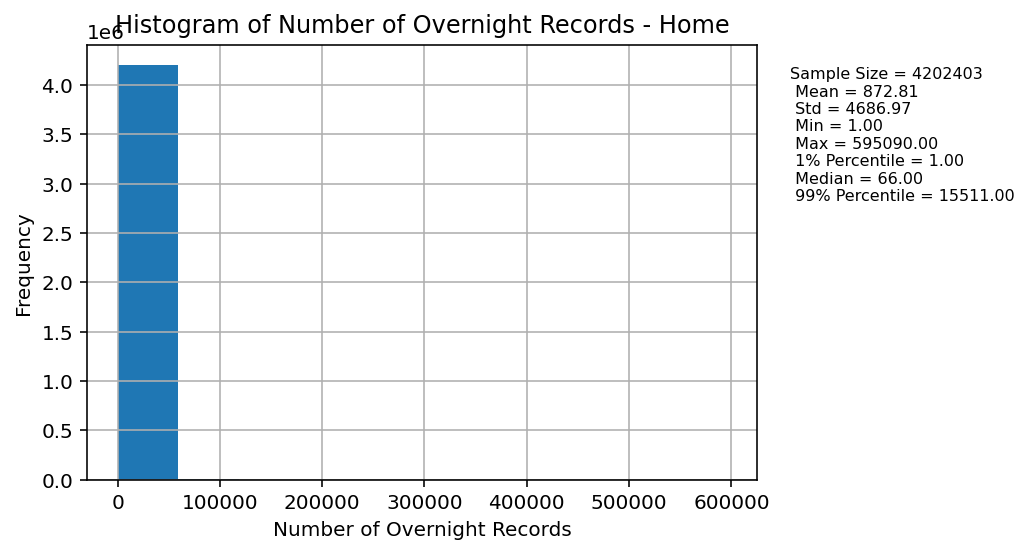

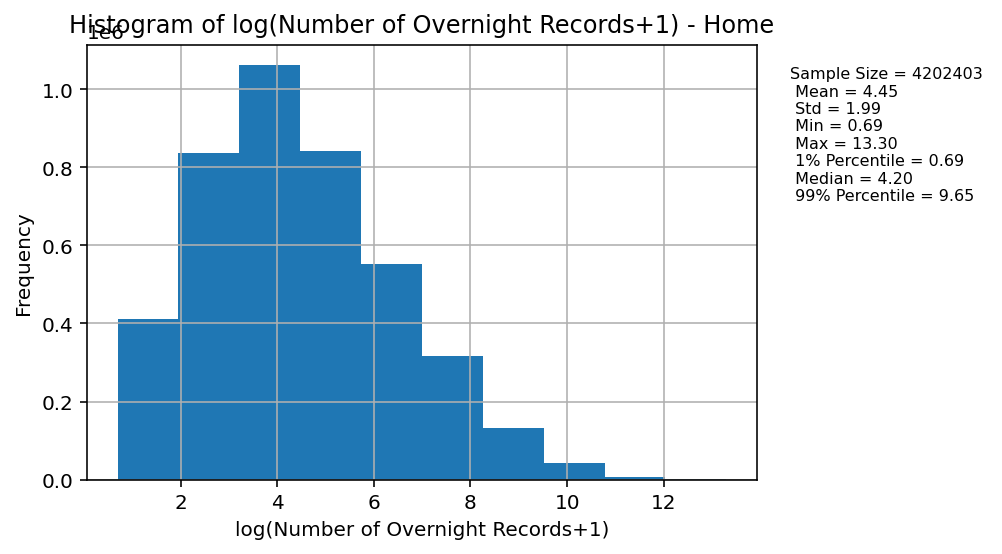

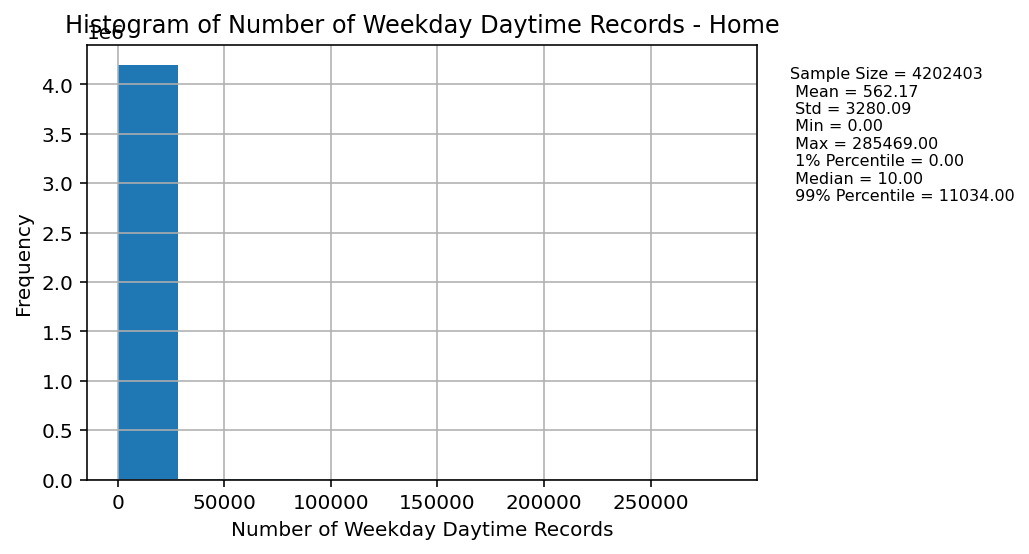

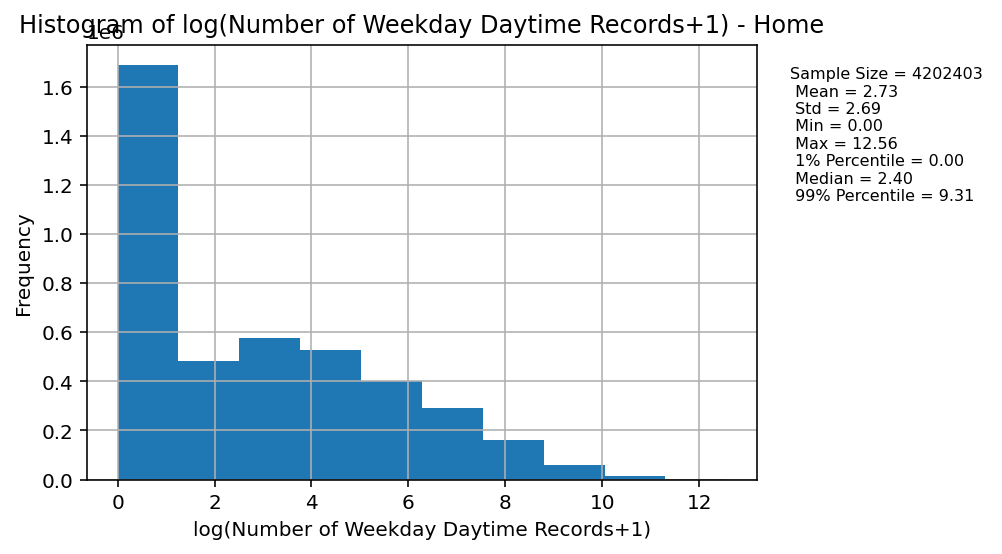

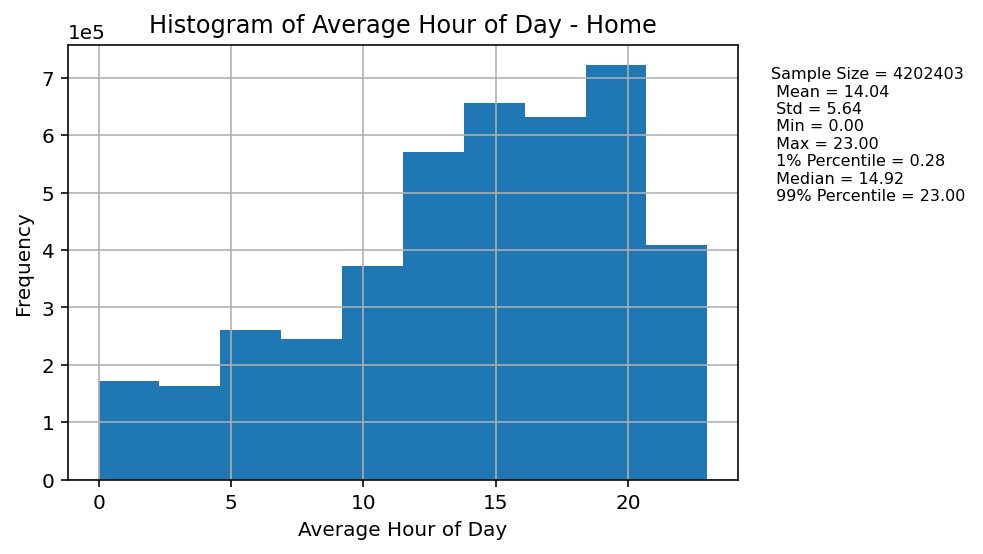

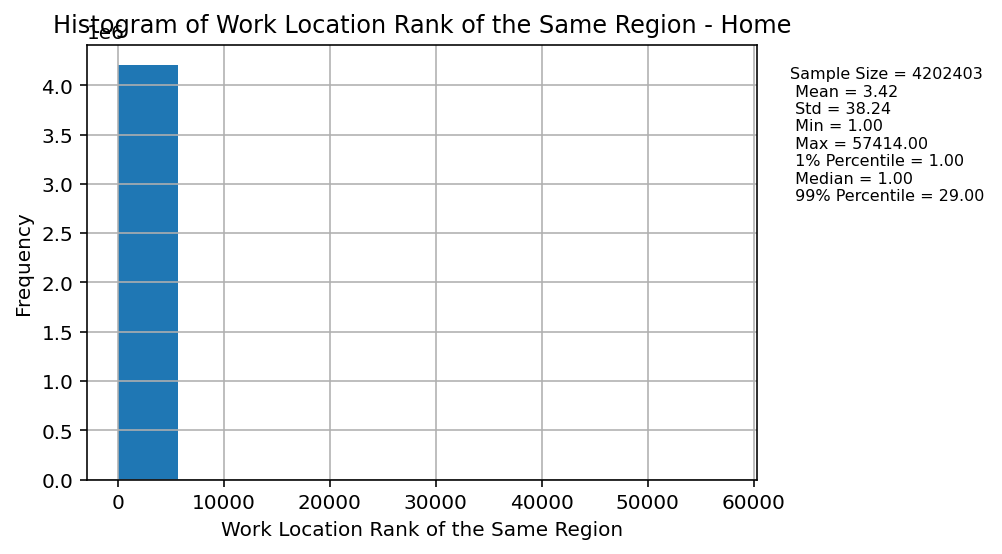

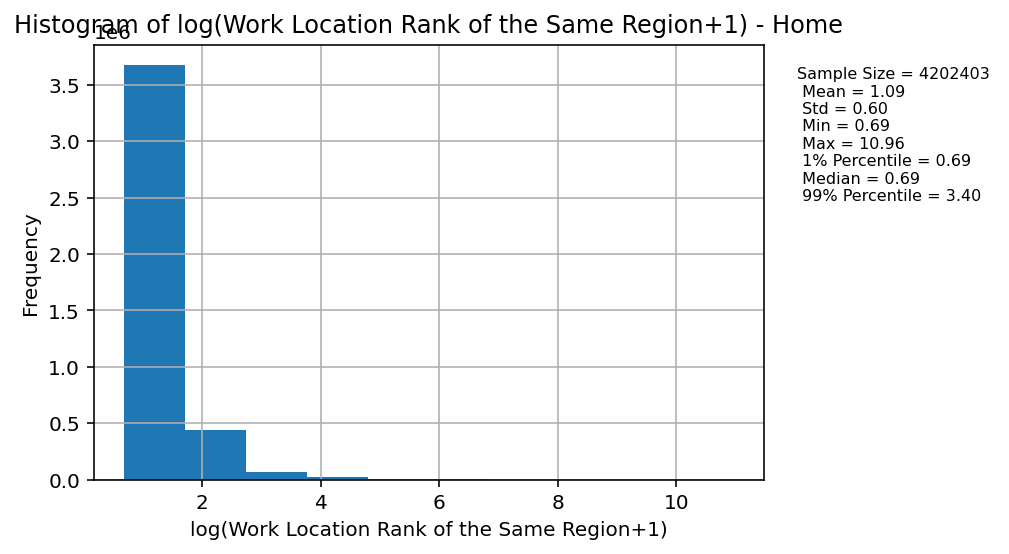

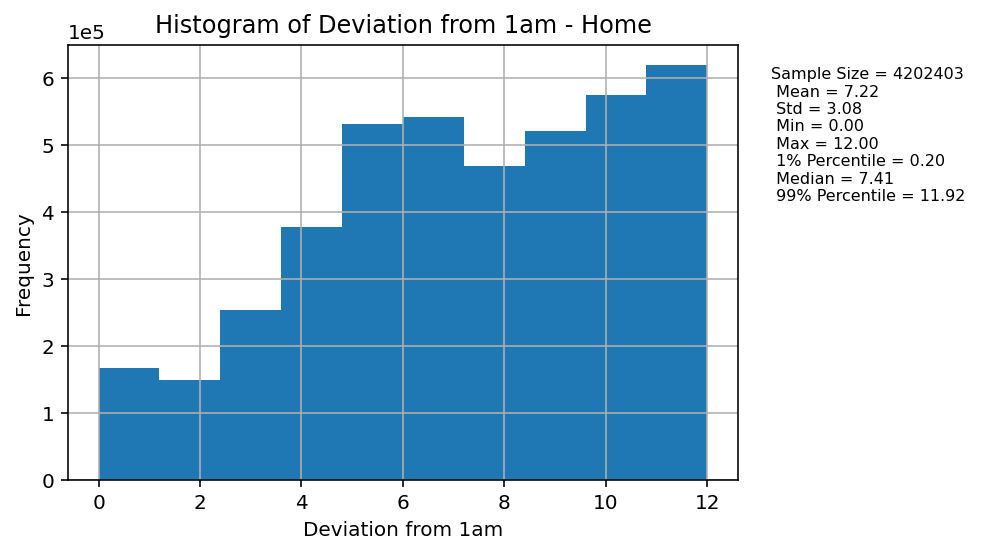

In [23]:
home_locations['lg_num_overnight'] = np.log(home_locations['num_records_overnight'] + 1)
home_locations['lg_num_weekday_daytime'] = np.log(home_locations['num_records_weekday_daytime'] + 1)
home_locations['lg_rank_work'] = np.log(home_locations['rank_work'] + 1)

for x in [['num_records_overnight','Number of Overnight Records'],
          ['lg_num_overnight','log(Number of Overnight Records+1)'],
          ['num_records_weekday_daytime', 'Number of Weekday Daytime Records'],
          ['lg_num_weekday_daytime','log(Number of Weekday Daytime Records+1)'],
          ['avg_hofd','Average Hour of Day'],
          ['rank_work','Work Location Rank of the Same Region'],
          ['lg_rank_work','log(Work Location Rank of the Same Region+1)'],
          ['dev_1am','Deviation from 1am']]:
    [size, mean, std, min, max, pct_1, median, pct_99]=["{:.0f}".format(home_locations[x[0]].count()),
                                                  "{:.2f}".format(home_locations[x[0]].mean()),
                                                  "{:.2f}".format(home_locations[x[0]].std()),
                                                  "{:.2f}".format(home_locations[x[0]].min()),
                                                  "{:.2f}".format(home_locations[x[0]].max()),
                                                  "{:.2f}".format(home_locations[x[0]].describe(percentiles=[0.01,0.99])[4]),
                                                  "{:.2f}".format(home_locations[x[0]].median()),                                    
                                                  "{:.2f}".format(home_locations[x[0]].describe(percentiles=[0.01,0.99])[6])]
    # histograms          
    fig, ax = plt.subplots()
    home_locations.hist(column=[x[0]], ax=ax)
    ax.text(1.05, 0.95, "Sample Size = {} \n Mean = {} \n Std = {} \n Min = {} \n Max = {} \n 1% Percentile = {} \n Median = {} \n 99% Percentile = {}".format(size, mean, std, min, max, pct_1, median, pct_99),
            transform=ax.transAxes, fontsize=8, verticalalignment='top')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.title("Histogram of {} - Home".format(x[1]))
    plt.xlabel(x[1])
    plt.ylabel("Frequency")
    fig.savefig(os.path.join(out, "hist_home_{}.pdf".format(x[0])), format='pdf', bbox_inches='tight', dpi='figure')

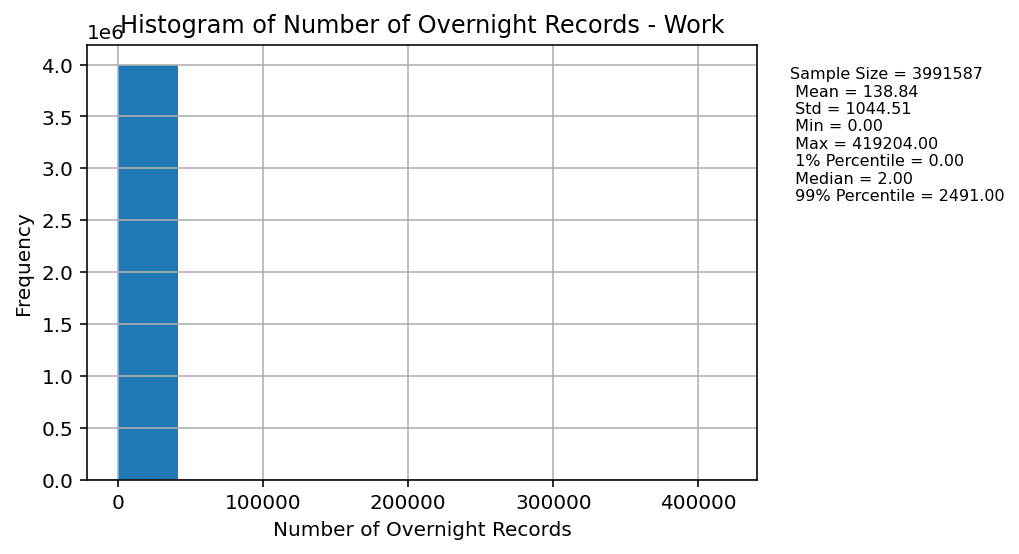

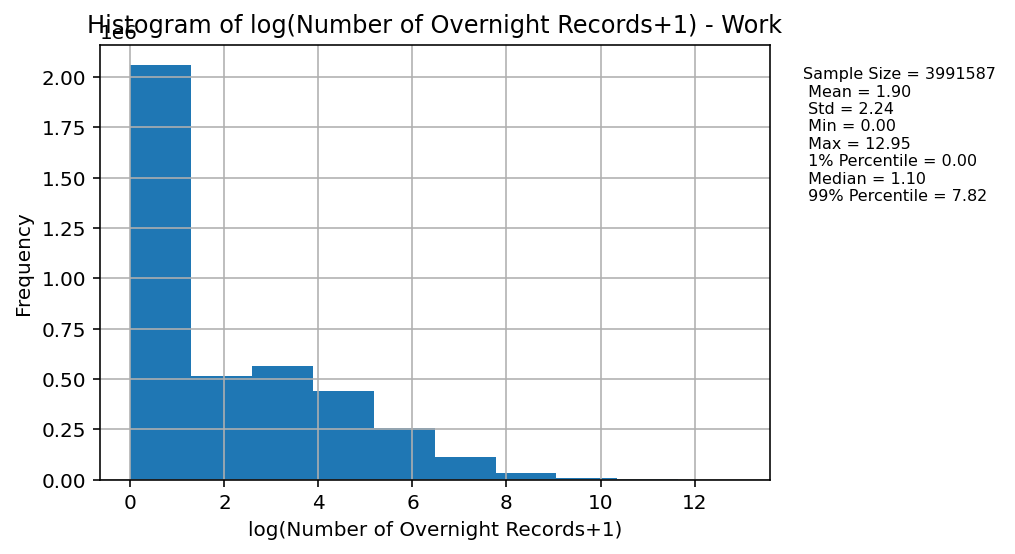

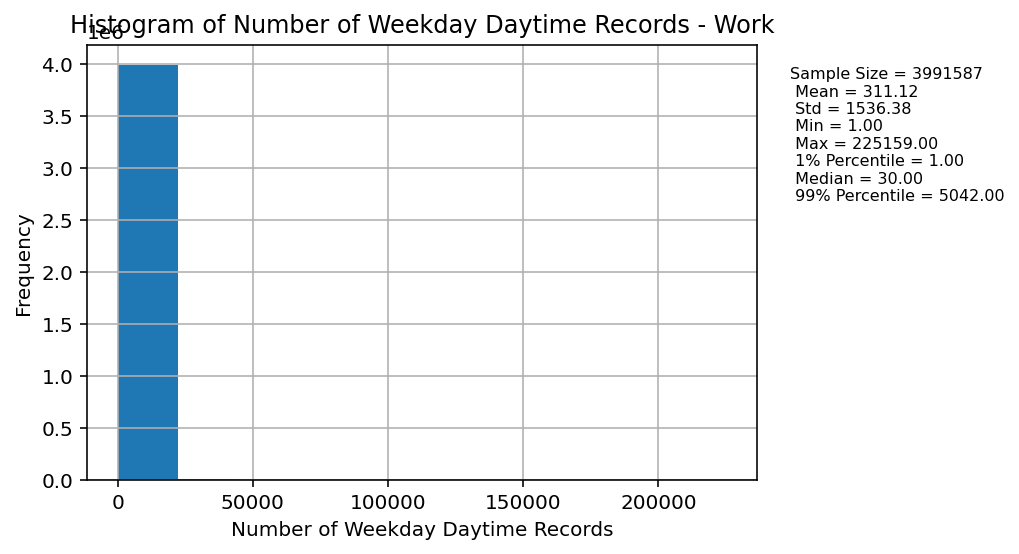

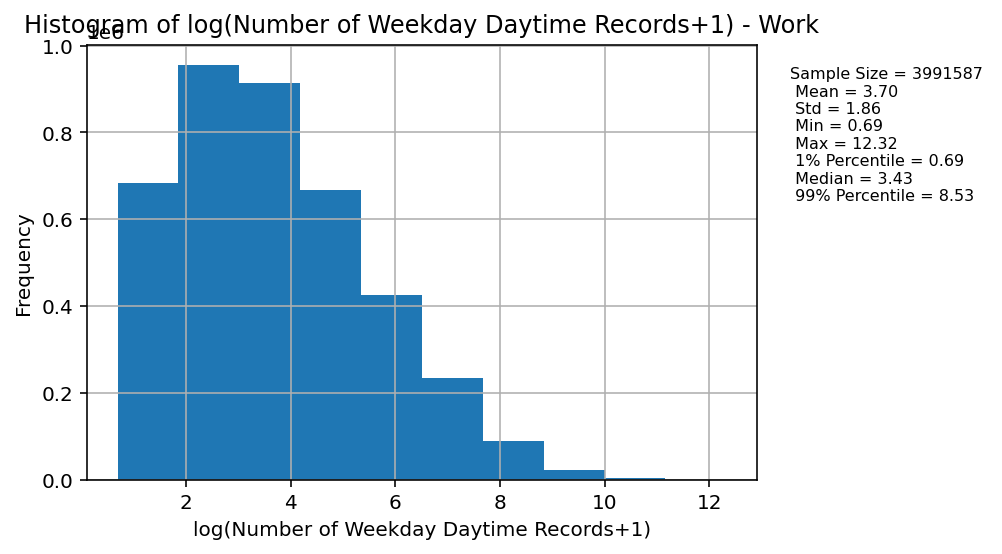

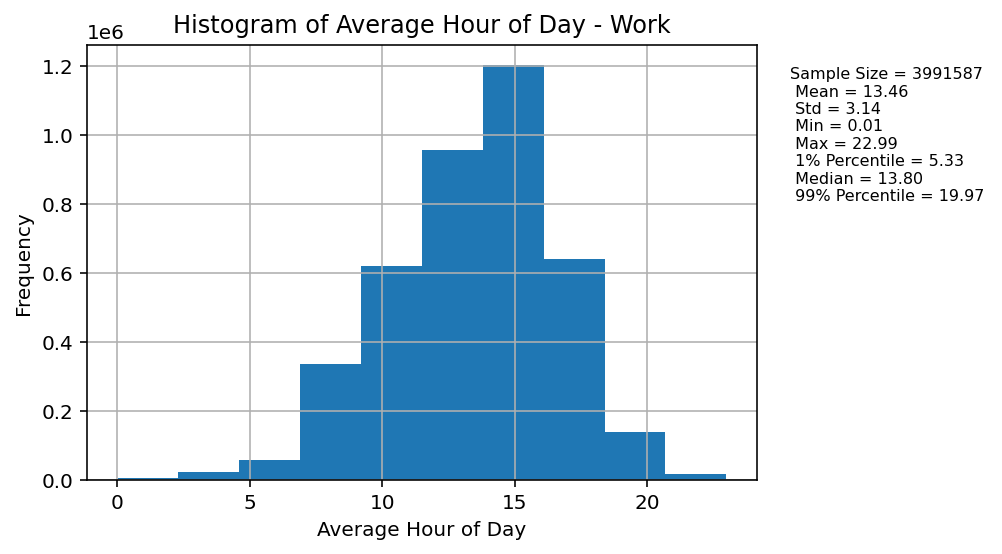

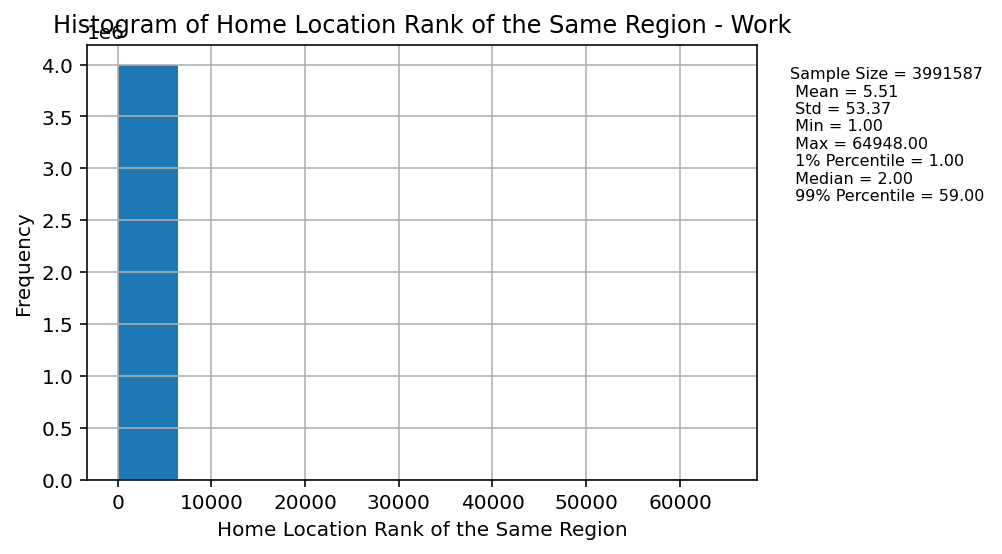

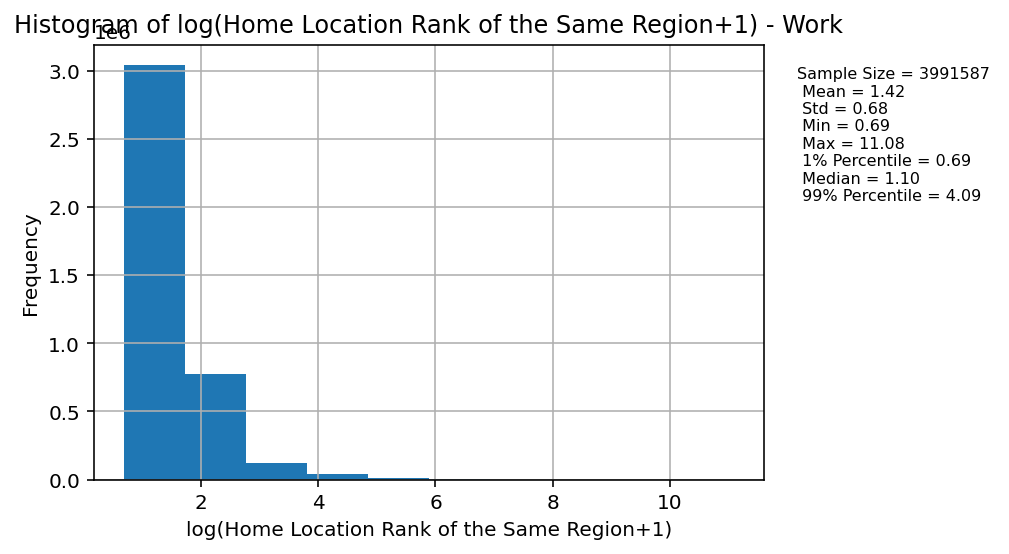

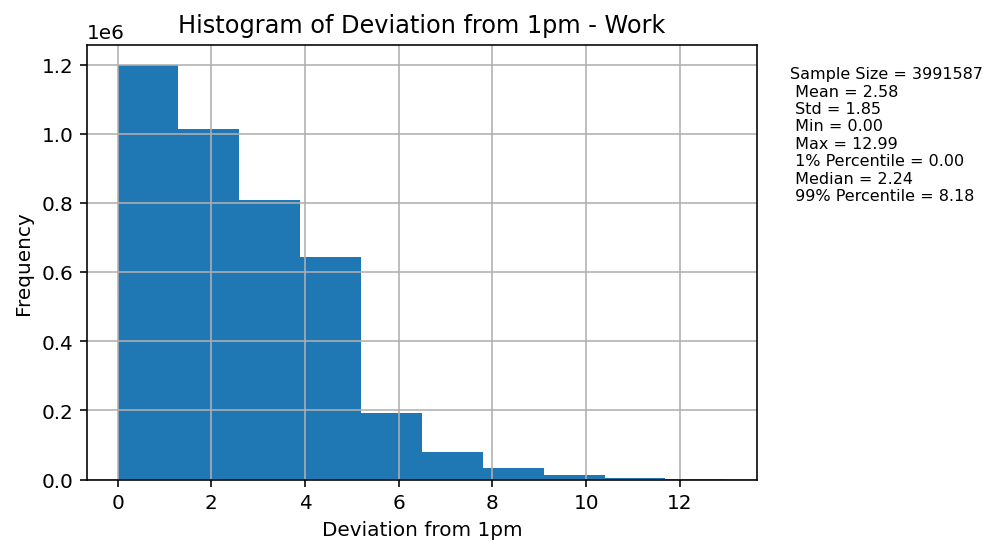

In [24]:
work_locations['lg_num_overnight'] = np.log(work_locations['num_records_overnight'] + 1)
work_locations['lg_num_weekday_daytime'] = np.log(work_locations['num_records_weekday_daytime'] + 1)
work_locations['lg_rank_home'] = np.log(work_locations['rank_home'] + 1)

for x in [['num_records_overnight','Number of Overnight Records'],
          ['lg_num_overnight','log(Number of Overnight Records+1)'],
          ['num_records_weekday_daytime', 'Number of Weekday Daytime Records'],
          ['lg_num_weekday_daytime','log(Number of Weekday Daytime Records+1)'],
          ['avg_hofd','Average Hour of Day'],
          ['rank_home','Home Location Rank of the Same Region'],
          ['lg_rank_home','log(Home Location Rank of the Same Region+1)'],
          ['dev_1pm','Deviation from 1pm']]:
    [size, mean, std, min, max, pct_1, median, pct_99]=["{:.0f}".format(work_locations[x[0]].count()),
                                                  "{:.2f}".format(work_locations[x[0]].mean()),
                                                  "{:.2f}".format(work_locations[x[0]].std()),
                                                  "{:.2f}".format(work_locations[x[0]].min()),
                                                  "{:.2f}".format(work_locations[x[0]].max()),
                                                  "{:.2f}".format(work_locations[x[0]].describe(percentiles=[0.01,0.99])[4]),
                                                  "{:.2f}".format(work_locations[x[0]].median()),                                    
                                                  "{:.2f}".format(work_locations[x[0]].describe(percentiles=[0.01,0.99])[6])]
    # histograms          
    fig, ax = plt.subplots()
    work_locations.hist(column=[x[0]], ax=ax)
    ax.text(1.05, 0.95, "Sample Size = {} \n Mean = {} \n Std = {} \n Min = {} \n Max = {} \n 1% Percentile = {} \n Median = {} \n 99% Percentile = {}".format(size, mean, std, min, max, pct_1, median, pct_99),
            transform=ax.transAxes, fontsize=8, verticalalignment='top')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.title("Histogram of {} - Work".format(x[1]))
    plt.xlabel(x[1])
    plt.ylabel("Frequency")
    fig.savefig(os.path.join(out, "hist_work_{}.pdf".format(x[0])), format='pdf', bbox_inches='tight', dpi='figure')

## Reverse Geocoding for Validation

In [4]:
# load data, a subset
file_path = path + '/Dropbox/Amenity/data/analysis/veraset_gravy_gps_sample'
home_sample = pd.read_csv(file_path + '/varaset_home_locations.csv', sep=',', nrows=5000,
                         encoding='latin-1', usecols=['caid','num_records_overnight','num_records_weekday_daytime','avg_lat','avg_lng','avg_hofd','geohash7','rank_home','rank_work','ties','dev_1am','rank_ties','still_ties'])
work_sample = pd.read_csv(file_path + '/varaset_work_locations.csv', sep=',', nrows=5000,
                         encoding='latin-1', usecols=['caid','num_records_overnight','num_records_weekday_daytime','avg_lat','avg_lng','avg_hofd','geohash7','rank_home','rank_work','ties','dev_1pm','rank_ties','still_ties'])

In [3]:
home_sample

,Unnamed: 0,caid,num_records_overnight,num_records_weekday_daytime,avg_lat,avg_lng,avg_hofd,geohash7,rank_home,rank_work,ties,dev_1am,rank_ties,still_ties
0,2,00000025e6f6a133694c2037f5bf2dee33224a6c6cb963...,52,0,34.960176,-120.435512,20.000000,9q4qgkm,1,8,False,5.000000,NaN,False
1,4,000008e0d27bdfd2bfa5b6d33694233e209fa627b6e0f4...,3,24,33.967308,-117.679718,17.333333,9qh34ps,1,1,False,7.666667,NaN,False
2,5,0000099f4be20d3f2d64236b5fec39eb70e2f82b912b0e...,4,3,37.792500,-122.412200,14.714286,9q8yyry,1,1,False,10.285714,NaN,False
3,6,00000bd1ed3e299f467d8da15e6f1e06e0e0119c82e601...,10,0,33.868100,-118.183100,4.666667,9q5bwtm,1,1,False,3.666667,NaN,False
4,8,00000bd2b7cfbd38d3a6c190c49c7673032bab3f0aa3d3...,1383,677,37.771576,-122.390082,15.938759,9q8yyun,1,1,False,9.061241,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11201,004ec749b3fa6f1fc184c6e8b723e9a80c4e1b9665a461...,116,37,33.989213,-117.561315,8.977654,9qh3kgd,1,2,False,7.977654,NaN,False
4996,11203,004eca7876b149b8dab92510513a043e311c1e917b5729...,21,0,34.192800,-118.488600,19.000000,9q5dx8x,1,2,False,6.000000,NaN,False
4997,11204,004ecf92b74e5bc0c199bab10017ae3b1c1a6050a86d45...,277,25,38.014175,-122.095092,9.109272,9qc0m8m,1,1,False,8.109272,NaN,False
4998,11206,004ed33430762edf83985e3e8874b71447f21d4389c82f...,6728,18697,34.523719,-117.363147,12.897245,9qhs3kf,1,1,False,11.897245,NaN,False


In [83]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="test_app")
home_sample['address'] = home_sample.apply(lambda x: geolocator.reverse("{}, {}".format(x['avg_lat'], x['avg_lng'])).raw['display_name'], axis=1)

home_sample.to_csv(path+'/Dropbox/Amenity/data/analysis/veraset_gravy_gps_sample/home_locations_reverse', sep=',', mode='w')

In [5]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="test_app")
work_sample['address'] = work_sample.apply(lambda x: geolocator.reverse("{}, {}".format(x['avg_lat'], x['avg_lng'])).raw['display_name'], axis=1)

work_sample.to_csv(path+'/Dropbox/Amenity/data/analysis/veraset_gravy_gps_sample/work_locations_reverse', sep=',', mode='w')

In [123]:
file = path + '/Dropbox/Amenity/data/analysis/veraset_gravy_gps_sample/home_locations_reverse.csv'
home_sample = pd.read_csv(file, sep=',', encoding='latin-1', usecols=['caid','num_records_overnight','num_records_weekday_daytime','avg_lat','avg_lng','avg_hofd','geohash7','rank_home','rank_work','ties','dev_1am','rank_ties','still_ties','address'])

In [135]:
%%stata -d home_sample

count if strpos(address, "Park")>1
count if strpos(address, "School")>1
count if strpos(address, "Cemetery")>1
count if strpos(address, "Mall")>1
count if strpos(address, "Gym")>1


  327

  202

  6

  9

  1



In [125]:
home_sample

,caid,num_records_overnight,num_records_weekday_daytime,avg_lat,avg_lng,avg_hofd,geohash7,rank_home,rank_work,ties,dev_1am,rank_ties,still_ties,address
0,00000025e6f6a133694c2037f5bf2dee33224a6c6cb963...,52,0,34.960176,-120.435512,20.000000,9q4qgkm,1,8,False,5.000000,NaN,False,"Rabobank, East Alvin Avenue, Santa Maria, Sant..."
1,000008e0d27bdfd2bfa5b6d33694233e209fa627b6e0f4...,3,24,33.967308,-117.679718,17.333333,9qh34ps,1,1,False,7.666667,NaN,False,"15780, El Prado Road, Chino, San Bernardino Co..."
2,0000099f4be20d3f2d64236b5fec39eb70e2f82b912b0e...,4,3,37.792500,-122.412200,14.714286,9q8yyry,1,1,False,10.285714,NaN,False,"Huntington Childrenâs Play Area, Sacramento ..."
3,00000bd1ed3e299f467d8da15e6f1e06e0e0119c82e601...,10,0,33.868100,-118.183100,4.666667,9q5bwtm,1,1,False,3.666667,NaN,False,"Harding Street, North Long Beach, Long Beach, ..."
4,00000bd2b7cfbd38d3a6c190c49c7673032bab3f0aa3d3...,1383,677,37.771576,-122.390082,15.938759,9q8yyun,1,1,False,9.061241,NaN,False,"Five 88, Mission Bay Boulevard North, Mission ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,004ec749b3fa6f1fc184c6e8b723e9a80c4e1b9665a461...,116,37,33.989213,-117.561315,8.977654,9qh3kgd,1,2,False,7.977654,NaN,False,"Ontario, San Bernardino County, California, 91..."
4996,004eca7876b149b8dab92510513a043e311c1e917b5729...,21,0,34.192800,-118.488600,19.000000,9q5dx8x,1,2,False,6.000000,NaN,False,"Van Nuys Golf Course, 6550, Odessa Avenue, Van..."
4997,004ecf92b74e5bc0c199bab10017ae3b1c1a6050a86d45...,277,25,38.014175,-122.095092,9.109272,9qc0m8m,1,1,False,8.109272,NaN,False,"3947, Via Estrella, Vine Hill, Contra Costa Co..."
4998,004ed33430762edf83985e3e8874b71447f21d4389c82f...,6728,18697,34.523719,-117.363147,12.897245,9qhs3kf,1,1,False,11.897245,NaN,False,"13737, Hidden Mesa Court, Victorville, San Ber..."
